Generate a movie for a single trajectory.

In [106]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

In [107]:
all_data_fp = "../../analysis_data/all_data.csv"

df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_56756/2574174746.py:3: DtypeWarning: Columns (15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,max_its,sender_delta,receiver_delta,min_epsilon,min_beta
0,1.526090e+00,1.270097,0.641931,2.278652,[0.0054146544510602634],0.012748,1.095495,0.0,simulation,NaN,...,0,replicator_diffusion,0,-8.0,6.0,200.0,NaN,NaN,NaN,NaN
1,0.000000e+00,0.000000,1.912028,16.399997,NaN,NaN,NaN,1.0,trajectory,0.0,...,0,replicator_diffusion,0,-8.0,6.0,200.0,NaN,NaN,NaN,NaN
2,0.000000e+00,0.000000,1.912028,16.330831,NaN,NaN,NaN,1.0,trajectory,1.0,...,0,replicator_diffusion,0,-8.0,6.0,200.0,NaN,NaN,NaN,NaN
3,0.000000e+00,0.000000,1.912028,16.278492,NaN,NaN,NaN,1.0,trajectory,2.0,...,0,replicator_diffusion,0,-8.0,6.0,200.0,NaN,NaN,NaN,NaN
4,8.881784e-16,0.000000,1.912028,16.236625,NaN,NaN,NaN,1.0,trajectory,3.0,...,0,replicator_diffusion,0,-8.0,6.0,200.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126171,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126172,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126173,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126174,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma='log10(0.5)'",
    "game.discriminative_need_gamma='log10(0.5)'", # important filter for movie
    "simulation.dynamics.population_init_gamma=-3",
    "simulation.dynamics.imprecise_imitation_gamma='log10(0.5)'",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.max_its=200", # important to specify maxits
    "seed=0",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


In [109]:
game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")


In [110]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma


    imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, np.nan]) # allows curve, and constraints to be the same as curve.

    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan])# allows curve

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma & max_its]

    return df_subsetted

In [111]:
# visualize the curve!
df = get_df_subsetted_by_meaning_dists(df, config)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,max_its,sender_delta,receiver_delta,min_epsilon,min_beta
107902,4.027770,3.774466,28.128707,6.361849,NaN,NaN,NaN,0.0,simulation,NaN,...,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,200.0,0.163581,0.176864,0.000965,1.437688
107903,5.758603,3.752014,35.886008,1779.352501,NaN,NaN,NaN,1.0,trajectory,1.0,...,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,200.0,173.649804,183.127410,0.742313,5.178137
107904,3.666112,3.397727,36.287339,44.250905,NaN,NaN,NaN,1.0,trajectory,2.0,...,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,200.0,17.547458,47.581877,0.108370,1.261809
107905,3.609271,3.393595,34.983539,37.847397,NaN,NaN,NaN,1.0,trajectory,3.0,...,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,200.0,10.748501,21.591260,0.067147,1.240704
107906,3.624934,3.422218,34.249095,31.582446,NaN,NaN,NaN,1.0,trajectory,4.0,...,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,200.0,10.081795,13.065608,0.051092,1.247739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126171,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126172,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126173,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126174,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# Edge cases where discriminative_need_gamma and meaning_dist_gamma are str types
for col in [
    "discriminative_need_gamma",
    "meaning_dist_gamma",
    "imprecise_imitation_gamma",
]:
    df[col].replace("log10(0.5)", np.log10(0.5), inplace=True)
    df[col] = df[col].astype(float)

In [97]:
# FURTHER restrict SIMULATION points to the settings we specified in config

df_emergent = df[(df["point_type"].isin(["simulation", "trajectory"]))]
#  & (df["discriminative_need_gamma"] == config.game.discriminative_need_gamma) & (df["population_init_gamma"] == config.simulation.dynamics.population_init_gamma)

#  & (df["seed"] == config.seed)

df_emergent

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,max_its,sender_delta,receiver_delta,min_epsilon,min_beta
111955,3.981908,3.743164,27.689078,6.674367,NaN,NaN,NaN,0.0,simulation,NaN,...,-0.30103,imprecise_conditional_imitation,-0.30103,2.0,0.0,100000.0,0.000137,0.000090,0.000125,1.416583
111956,5.908974,3.895665,37.384006,1719.343811,NaN,NaN,NaN,1.0,trajectory,1.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,2.0,0.0,100000.0,175.737798,187.351443,0.626277,5.711411
111957,3.660867,3.399385,33.223744,37.767775,NaN,NaN,NaN,1.0,trajectory,2.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,2.0,0.0,100000.0,25.358442,61.774901,0.102555,1.261809
111958,3.566105,3.375400,32.331798,10.713790,NaN,NaN,NaN,1.0,trajectory,3.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,2.0,0.0,100000.0,11.326831,22.899602,0.050408,1.226633
111959,3.588307,3.407908,32.418426,10.254160,NaN,NaN,NaN,1.0,trajectory,4.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,2.0,0.0,100000.0,9.019648,13.585161,0.035920,1.233668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113319,3.981923,3.743174,34.763568,6.674281,NaN,NaN,NaN,1.0,trajectory,35111.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,-2.0,0.0,100000.0,0.000134,0.000074,0.000124,1.416583
113320,3.981923,3.743175,34.763144,6.674280,NaN,NaN,NaN,1.0,trajectory,37649.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,-2.0,0.0,100000.0,0.000124,0.000069,0.000124,1.416583
113321,3.981923,3.743175,34.762717,6.674280,NaN,NaN,NaN,1.0,trajectory,40370.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,-2.0,0.0,100000.0,0.000115,0.000064,0.000124,1.416583
113322,3.981923,3.743175,34.762295,6.674279,NaN,NaN,NaN,1.0,trajectory,43287.0,...,-0.30103,imprecise_conditional_imitation,-0.30103,-2.0,0.0,100000.0,0.000106,0.000060,0.000124,1.416583


In [98]:
df_sim_points = df_emergent[df_emergent["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

In [99]:
# convert seed to categorical
df_sim_points.seed = df_final_points.seed.astype(str)

In [100]:
df_sim_points.discriminative_need_gamma = df_sim_points.discriminative_need_gamma.astype(str)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


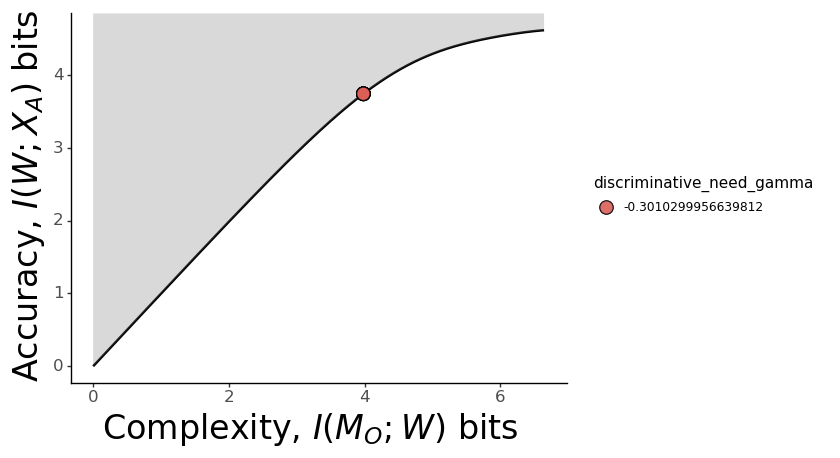

In [101]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_sim_points,
        mapping=pn.aes(
            # shape="seed",
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        # fill = "#440154",
        alpha=0.9,
        size=5,
    )        
        + pn.xlim([0,np.log2(100)])
        + pn.xlab("Complexity, $I(M_O;W)$ bits")
        + pn.ylab("Accuracy, $I(W;X_A)$ bits")
        # + pn.ylab("Informativeness, $I(W;U)$ bits")


        + pn.theme_classic()
        + pn.theme(
            # Axis font
            axis_title=pn.element_text(size=24),
            axis_text=pn.element_text(size=12),
            # Legend position
            # legend_position=(0.75, 0.4),
            # legend_position='none',
        )    
)
print(plot)

In [102]:
def bound_plot_time_step(df_t: pd.DataFrame, t: str) -> pn.ggplot:
    return (
        # Set data and the axes
        pn.ggplot(
            data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
        )  
        + pn.geom_line(size=1) # IB curve
        # + pn.geom_point(size=1)
        + pn.geom_ribbon(
        mapping=pn.aes(
            x="complexity",
            ymin="accuracy",
            ymax=np.inf,
            ),
            fill="gray",
            alpha=0.3,
        )
        + pn.geom_point( # emergent langs
            data=df_t,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
            # fill = "#440154",
            alpha=0.9,
            size=5,
        )        
        + pn.xlim([0,np.log2(100)])
        + pn.xlab("Complexity, $I(M_O;W)$ bits")
        + pn.ylab("Accuracy, $I(W;X_A)$ bits")
        # + pn.ylab("Informativeness, $I(W;U)$ bits")
        + pn.ggtitle(f"t={t+1}")

        + pn.theme_classic()
        + pn.theme(
            # Axis font
            axis_title=pn.element_text(size=24),
            axis_text=pn.element_text(size=12),
            # Legend position
            # legend_position=(0.75, 0.4),
            legend_position='none',
        )    

    )
    

In [104]:
df_traj = df_emergent[df_emergent["point_type"] == "trajectory"]
df_traj["t"] = df_traj["round"]

for time_step in range(200):
    plot = bound_plot_time_step(df_traj[df_traj["t"] == time_step], time_step)
    plot.save(f"bound_movie/plots/t_{int(time_step)}.png", width=8, height=8, dpi=300,)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 8 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: bound_movie/plots/t_0.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 8 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: bound_movie/plots/t_1.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot

In [105]:
# Run ffmpeg command
import os
os.system("ffmpeg -f image2 -framerate 10 -i  ./bound_movie/plots/t_%d.png -vcodec mpeg4 -y ./bound_movie/movie/trajectory_on_bound.mp4")

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

0